## 모듈 임포트

In [1]:
from selenium.webdriver.chrome.options import Options
from selenium import webdriver
from selenium.webdriver.common.by import By

from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
plt.rc('font', family='Malgun Gothic')

## 스크래핑 함수 작성

In [2]:
# 페이지가 닫히지 않도록 하는 옵션 설정
def set_option():
    options = Options()
    options.add_experimental_option("detach", True)
    driver = webdriver.Chrome(options=options)
    return driver

In [3]:
# select_idx 는 select 요소 두 개중 어느 것을 선택할건지
# text는 클릭하고 싶은 년도
# combo_idx는 그 텍스트가 page내에서 몇번째인지(콤보박스 위에 년도가 있어도 하나로 친다.)
# 현재 클릭된 년도를 나타내는 텍스트가 화면에 출력되기 때문에 두 번째 년도를 찾으려면 인덱스를 2로 해야한다.
def select_element_click(driver, select_idx, text, combo_idx):
    driver.find_elements(By.CSS_SELECTOR, 'div.ant-select.ant-select-enabled')[select_idx].click()
    option = driver.find_elements(By.XPATH, f"//*[text()='{text}']")[combo_idx]
    driver.execute_script("arguments[0].scrollIntoView();", option)
    option.click()

In [4]:
# select 요소를 클릭하고 페이지 소스를 받아와서 beautifulsoup로 스크래핑한다.
FILE_PATH = "DATA/한국인_이름_통계_2008_2024.xlsx"

if os.path.exists(FILE_PATH):
    print(f"{FILE_PATH} 파일이 존재합니다.")

else:
    driver = set_option()
    
    driver.get('https://koreanname.me/')
    driver.implicitly_wait(3)
    
    years = [f'{i} 년' for i in range(2008, 2025)]
    
    pages = {}

    # 년도 선택
    for year in years:
        select_element_click(driver, 0, year, 0)
        time.sleep(3)
        select_element_click(driver, 1, year, 2)
        time.sleep(3)
        pages[year] = driver.page_source
        time.sleep(3)
    
    driver.quit()

DATA/한국인_이름_통계_2008_2024.xlsx 파일이 존재합니다.


In [5]:
def get_row_by_gender(soup, gender):
    gender_tr = soup.select('tr')
    gender_row = []
    
    for tr in gender_tr:
        one_row = []
        for td in tr.select('td'):
            one_row.append(td.get_text())
        one_row.append(gender)
        gender_row.append(one_row)
    return gender_row

In [6]:
if os.path.exists(FILE_PATH):
    print(f"{FILE_PATH} 파일이 존재합니다.")

else:
    dfs_for_concat = []
    for year in years:
        soup = BeautifulSoup(pages[year], 'html.parser')
        
        male = soup.select('tbody.ant-table-tbody')[0]
        female = soup.select('tbody.ant-table-tbody')[1]
    
        male_row = get_row_by_gender(male, "남")
        female_row = get_row_by_gender(female, "여")
    
        temp_df = pd.DataFrame(male_row + female_row)
        temp_df['연도'] = year
    
        dfs_for_concat.append(temp_df)
        
    total_df = pd.concat(dfs_for_concat, ignore_index=True)

DATA/한국인_이름_통계_2008_2024.xlsx 파일이 존재합니다.


In [7]:
if os.path.exists(FILE_PATH):
    print(f"{FILE_PATH} 파일이 존재합니다.")

else:
    total_df = total_df.rename(columns={0:"이름", 1:"랭킹", 2:"이름수", 3:"성별"})
    total_df = total_df[["연도", "성별", "이름", "랭킹", "이름수"]]
    total_df.head()

DATA/한국인_이름_통계_2008_2024.xlsx 파일이 존재합니다.


In [8]:
if os.path.exists(FILE_PATH):
    print(f"{FILE_PATH} 파일이 존재합니다.")
else:
    total_df.to_excel("DATA/한국인_이름_통계_2018_2024.xlsx",index=False)

DATA/한국인_이름_통계_2008_2024.xlsx 파일이 존재합니다.


## 데이터 전처리

In [9]:
df = pd.read_excel("DATA/한국인_이름_통계_2008_2024.xlsx")

In [10]:
df.head()

,연도,성별,이름,랭킹,이름수
0,2008 년,남,민준,1,"2,656"
1,2008 년,남,지훈,2,"2,191"
2,2008 년,남,현우,3,"1,947"
3,2008 년,남,준서,4,"1,905"
4,2008 년,남,우진,5,"1,827"


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   연도      3400 non-null   object
 1   성별      3400 non-null   object
 2   이름      3400 non-null   object
 3   랭킹      3400 non-null   int64 
 4   이름수     3400 non-null   object
dtypes: int64(1), object(4)
memory usage: 132.9+ KB


In [12]:
df['이름수'] = df["이름수"].str.replace(",", "")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   연도      3400 non-null   object
 1   성별      3400 non-null   object
 2   이름      3400 non-null   object
 3   랭킹      3400 non-null   int64 
 4   이름수     3400 non-null   object
dtypes: int64(1), object(4)
memory usage: 132.9+ KB


## 이름 인기 순위 시각화

In [13]:
# 각 년도 랭킹 top5 이름들이 향후 랭킹의 흐름을 파악하는 함수(시각화)
def get_ranking_from_top5_names_in_year(gender, start_year):
    conditions = (df['성별'] == gender) & (df['연도'] == start_year)
    top5_year = df.loc[conditions, "이름"].head()
    
    names = top5_year.values
    
    years = [f'{i} 년' for i in range(2008, 2025)]
    top5_rank_after_2008 = {}
    
    for name in names:
        rank_lst = []
        for year in years:
            conditions = (df['이름'] == name) & (df['연도'] == year)
            rk = df.loc[conditions, "랭킹"]
            if len(rk) != 0:
                rank_lst.append(rk.iloc[0])
            else:
                rank_lst.append(np.inf)
        top5_rank_after_2008[f'{name}'] = rank_lst
        
    top5_df = pd.DataFrame(top5_rank_after_2008)
    top5_df.index = [f'{i}년' for i in range(2008, 2025)]

    plt.plot(top5_df, label=top5_df.columns, marker='o', ms=3)

    plt.title(f"<{start_year} top5 이름들 전체기간 랭킹 변화 추이>")
    plt.ylabel("랭킹")
    plt.legend()
    plt.gca().invert_yaxis()
    plt.xticks(top5_df.index[::2])  # 2년마다 라벨 표시
    
    # return top5_df

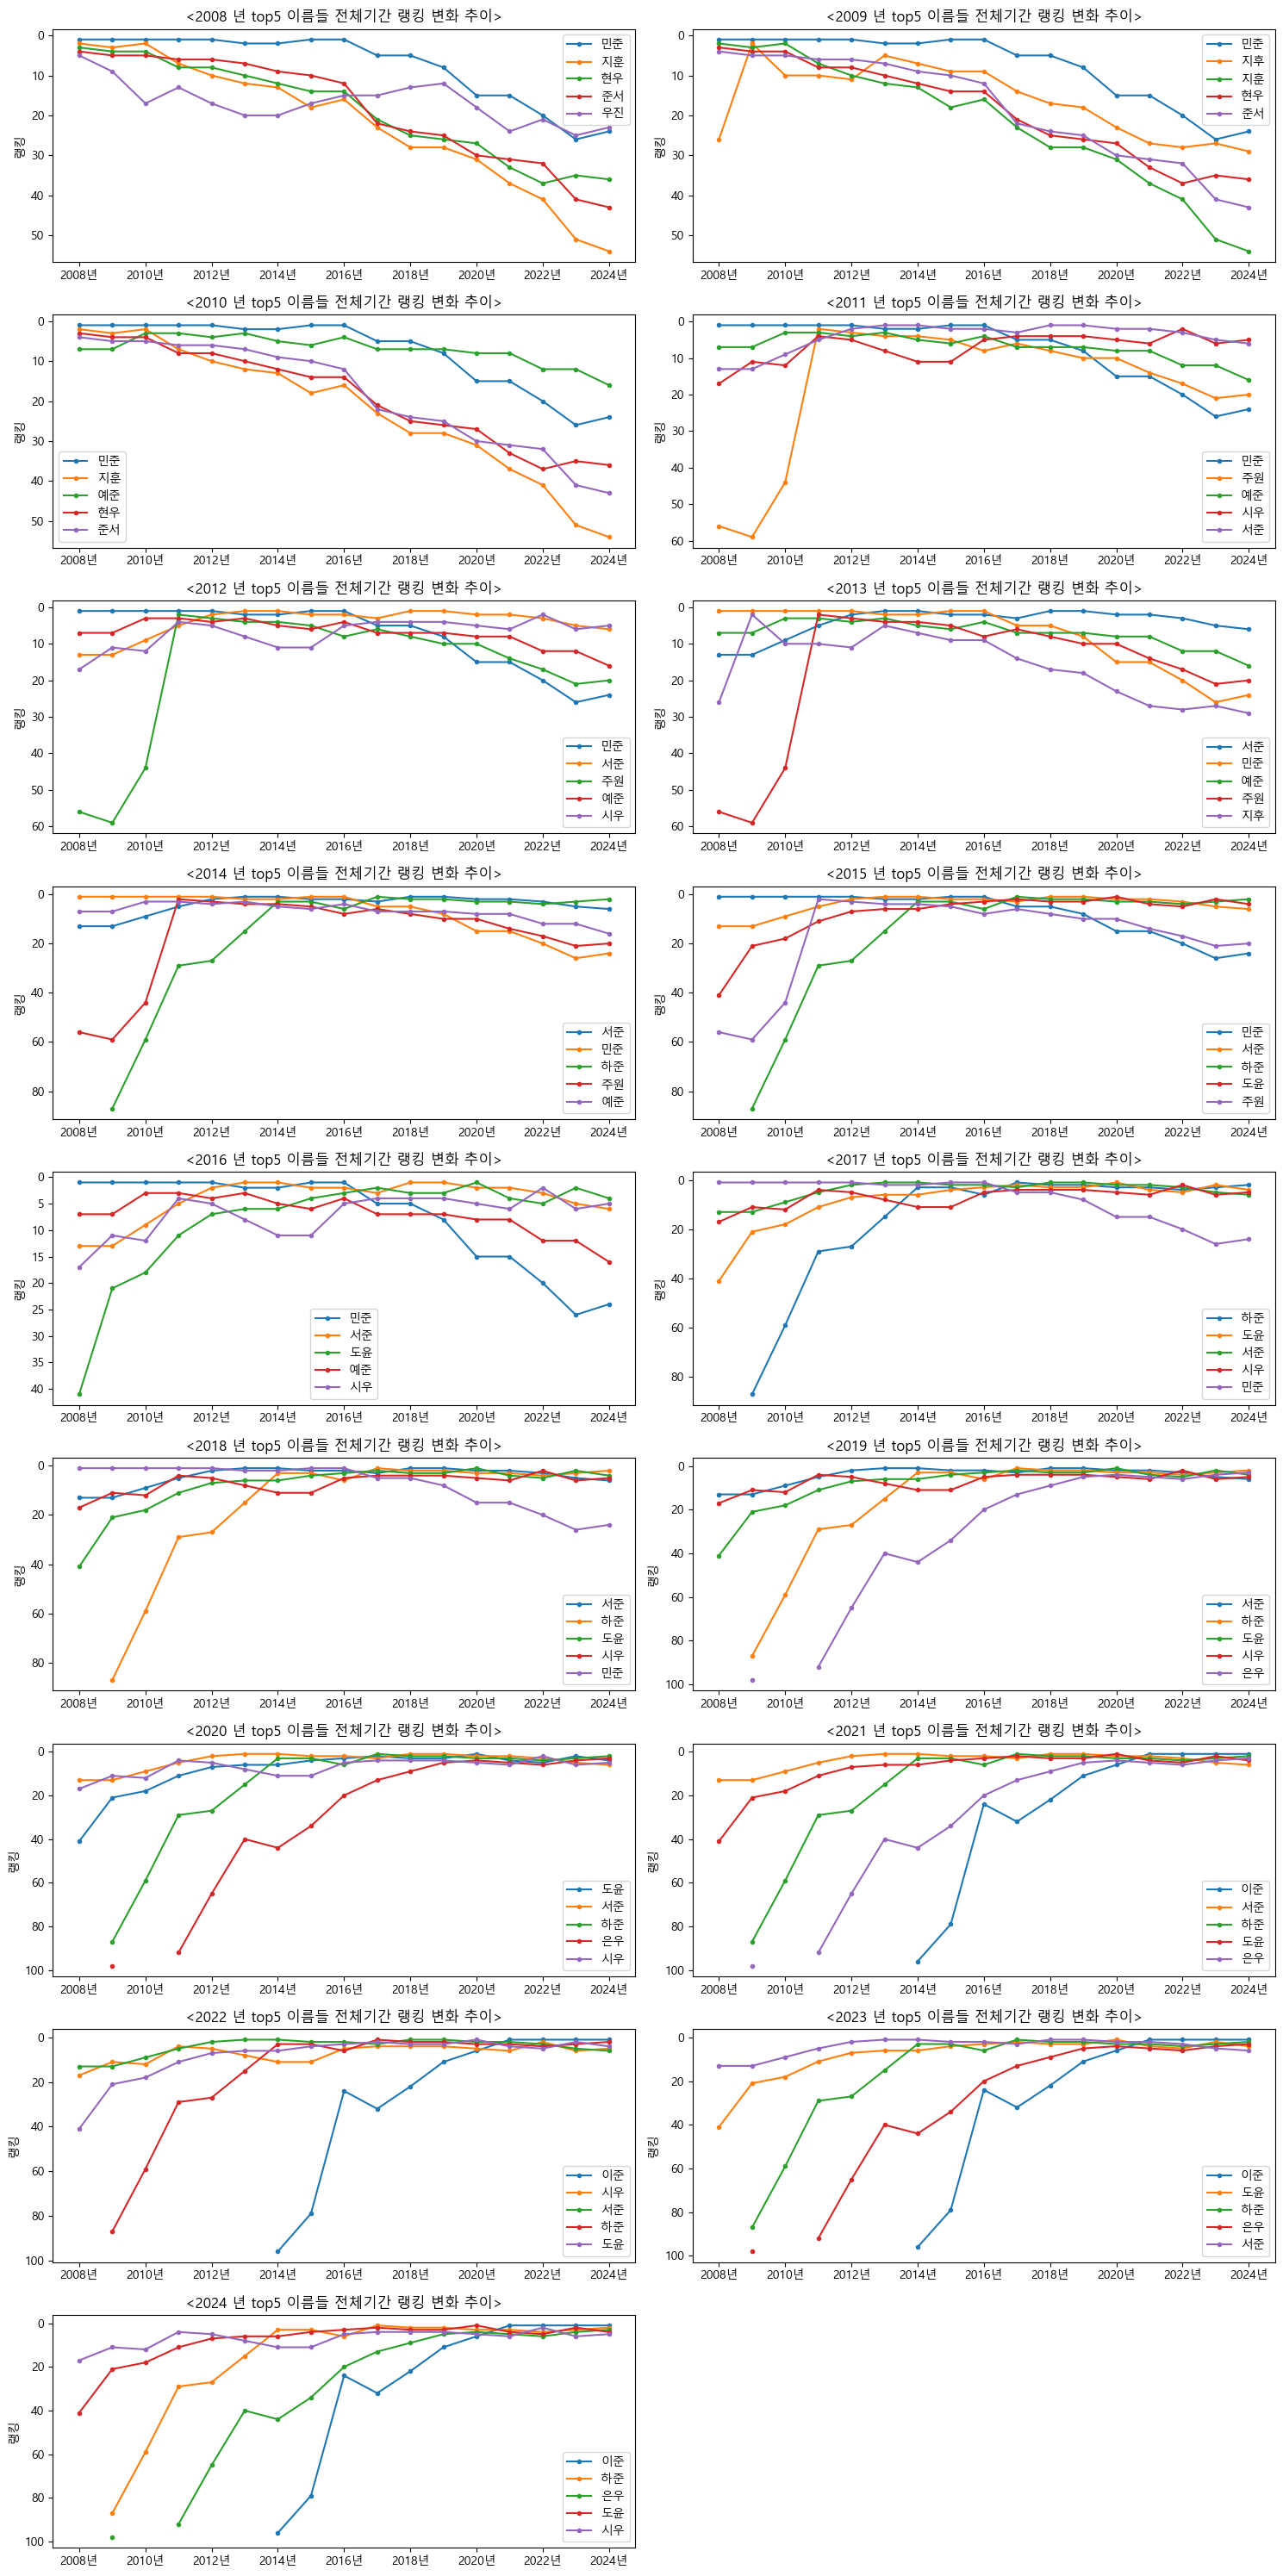

In [14]:
years = [f'{i} 년' for i in range(2008, 2025)]

plt.figure(figsize=(15, 30))

for i, year in enumerate(years):
    plt.subplot(9, 2, i+1)
    get_ranking_from_top5_names_in_year("남", year)

plt.tight_layout()
plt.show()